In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import scipy.stats as stats
import tabulate as tb
from typing import Literal, List, Tuple
import scipy
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import glob
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg

In [109]:
RES_PATH = './res/'
ROC_PREFIX='roc'
SUMM_PREFIX='res'

In [110]:
summary_files = [os.path.join(RES_PATH, f) for f in os.listdir(RES_PATH) if f.startswith(SUMM_PREFIX) and f.endswith('.csv')]
print("Summary files found:", summary_files)

df_all = pd.DataFrame()
for file in summary_files:
    try:
        temp_df = pd.read_csv(file)
        df_all = pd.concat([df_all, temp_df], ignore_index=True)
    except Exception as e:
        print(f"Error reading {file}: {e}")
        
df_all['precision'] = df_all['TP'] / (df_all['TP'] + df_all['FP'])
df_all['recall'] = df_all['TP'] / (df_all['TP'] + df_all['FN'])
df_all['f1_score'] = 2 * (df_all['precision'] * df_all['recall']) / (df_all['precision'] + df_all['recall'])
df_all = df_all.rename(columns={'model_name': 'model'})
df_all['model'] = df_all['model'].replace({
    'efficientnetv2': 'EfficientNetV2S',
    'mobilenetv2': 'MobileNetV2'
    })

print(tb.tabulate(df_all, headers='keys', tablefmt='psql'))

Summary files found: ['./res/res_sex_efficientnetv2.csv', './res/res_sex_mobilenetv2.csv']
+----+-------+-----------------+---------------------+--------------+----------------------+-------------+---------------------+---------------------------+---------------------------+---------------+--------------+------------+------+------+------+------+--------------------+--------------------+-------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+-------------+----------+------------+
|    |   rep | model           | feature_split_col   |   train_size | train_ratio_detail   |   test_size | test_ratio_detail   | train_ratio_rel           | test_ratio_rel            | train_ratio   | test_ratio   |   ac

Accuracy Table (feature=sex, train ratio=2/8):
+-------------+----------------------+------------------+-------------------------+---------------------+
| TestRatio   |   AccEfficientNetV2S |   AccMobileNetV2 |   AccStdEfficientNetV2S |   AccStdMobileNetV2 |
|-------------+----------------------+------------------+-------------------------+---------------------|
| 1/9         |                0.953 |            0.517 |              0.00141421 |           0.0268701 |
| 2/8         |                0.95  |            0.518 |              0.00848528 |           0.0367696 |
| 3/7         |                0.939 |            0.519 |              0.00989949 |           0.0410122 |
| 4/6         |                0.931 |            0.522 |              0.00989949 |           0.0339411 |
| 5/5         |                0.931 |            0.515 |              0.0127279  |           0.0353553 |
| 6/4         |                0.916 |            0.511 |              0.0141421  |           0.0410122 |

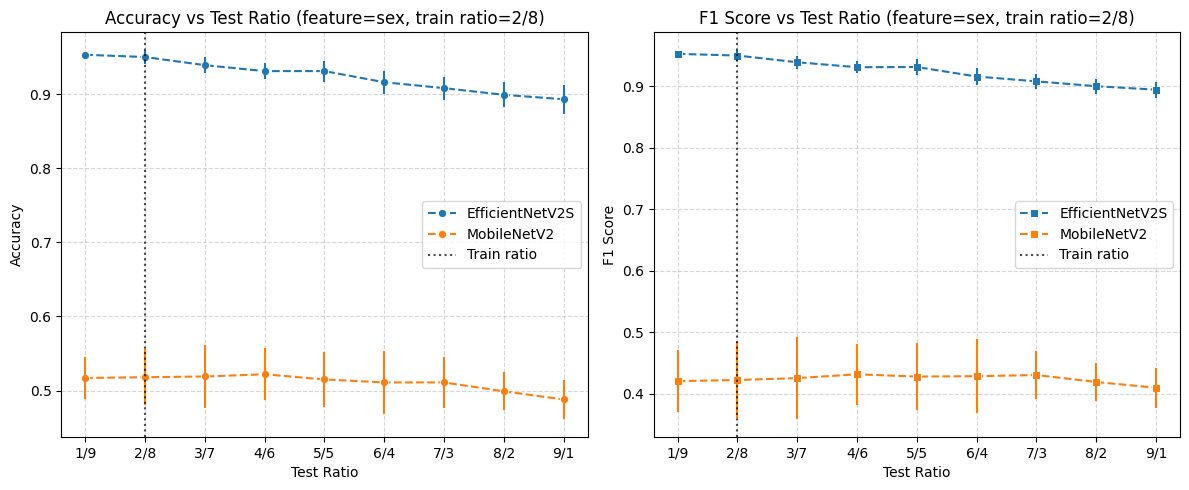

In [111]:
def handle_base_metrics(df_org, feature, train_ratio):
    df = df_org[(df_org['train_ratio'] == train_ratio) & (df_org['feature_split_col'] == feature)].copy()
    df['test_ratio'] = pd.Categorical(
            df['test_ratio'], 
            categories=sorted(df['test_ratio'].unique(), key=lambda x: eval(x.replace('/', ','))),
            ordered=True
        )
    
    def create_plt():
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

        
        
        # Accuracy
        acc_plot = sns.lineplot(
            data=df,
            x='test_ratio',
            y='accuracy',
            hue='model',
            marker='o',
            linestyle='--',
            err_style='bars',
            errorbar='sd',
            ax=axes[0]
        )
        axes[0].set_title(f'Accuracy vs Test Ratio (feature={feature}, train ratio={train_ratio})')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_xlabel('Test Ratio')
        #axes[0].set_ylim(0.85, 1.0)
        axes[0].grid(True, linestyle='--', alpha=0.5)

        # F1
        f1_plot = sns.lineplot(
            data=df,
            x='test_ratio',
            y='f1_score',
            hue='model',
            marker='s',
            linestyle='--',
            err_style='bars',
            errorbar='sd',
            ax=axes[1]
        )
        axes[1].set_title(f'F1 Score vs Test Ratio (feature={feature}, train ratio={train_ratio})')
        axes[1].set_ylabel('F1 Score')
        axes[1].set_xlabel('Test Ratio')
        #axes[1].set_ylim(0.85, 1.0)
        axes[1].grid(True, linestyle='--', alpha=0.5)

        # 🔷 Add vertical line
        if train_ratio in df['test_ratio'].unique():
            axes[0].axvline(x=train_ratio, color='black', linestyle=':', alpha=0.7, label='Train ratio')
            axes[1].axvline(x=train_ratio, color='black', linestyle=':', alpha=0.7, label='Train ratio')
            axes[0].legend(title=None)
            axes[1].legend(title=None)
        plt.tight_layout()
        plt.show()

    def create_table():
        tmp = df.groupby(['test_ratio','model'], observed=False).agg(
            TestRatio=('test_ratio', 'first'),
            Model=('model', 'first'),
            Acc=('accuracy', 'mean'),
            AccStd=('accuracy', 'std'),
            FI=('f1_score', 'mean'),
            FiStd=('f1_score', 'std')
        ).reset_index(drop=True)
        
        tmp_acc = tmp.pivot(index='TestRatio', columns='Model', values=['Acc', 'AccStd'])
        tmp_acc.columns = [f'{metric}{model}' for metric, model in tmp_acc.columns]
        
        tmp_f1 = tmp.pivot(index='TestRatio', columns='Model', values=['FI', 'FiStd'])
        tmp_f1.columns = [f'{metric}{model}' for metric, model in tmp_f1.columns]

        print(f"Accuracy Table (feature={feature}, train ratio={train_ratio}):")        
        print(tb.tabulate(tmp_acc, headers='keys', tablefmt='psql'))
        
        print(f"F1 Score Table (feature={feature}, train ratio={train_ratio}):")
        print(tb.tabulate(tmp_f1, headers='keys', tablefmt='psql'))
        
    create_table()
    create_plt()
    
handle_base_metrics(df_all, 'sex', '2/8')

In [116]:
def handle_base_metrics(df_org, feature, train_ratio, value):
    df = df_org[(df_org['train_ratio'] == train_ratio) & (df_org['feature_split_col'] == feature)].copy()
    df['test_ratio'] = pd.Categorical(
            df['test_ratio'], 
            categories=sorted(df['test_ratio'].unique(), key=lambda x: eval(x.replace('/', ','))),
            ordered=True)
    
    res = []
    for test_ratio in df['test_ratio'].unique():
        columns = ["Test ratio"]
        single = [test_ratio]
        all_normal = True
        for model in df['model'].unique():
            df_tmp = df[(df['test_ratio'] == test_ratio) & (df['model'] == model)]
            
            shapiro_p = stats.shapiro(df_tmp[value])[1]
            is_normal = shapiro_p > 0.05
            if not is_normal:
                all_normal = False
            single.append(f'Shapiro: p={shapiro_p:.3}')
            columns.append(f'{model} normality')
        
        levene_data = df_tmp[value].values
        if all_normal:
            stat, p_leve = stats.levene(*levene_data, center='mean')
            single.append(f'Levene (mean): p={p_leve:.3}')
        else:
            stat, p_leve = stats.levene(*levene_data, center='median')
            single.append(f'Levene (median): p={p_leve:.3}')
        is_variance_equal = p_leve > 0.05
        columns.append('Variance equality')
        
        if all_normal and is_variance_equal:
            anova_results = pg.anova(data=df, dv=value, between='model')
            name_anova = 'ANOVA'
            poc_name = 'Tukey'
            poc_results = pairwise_tukeyhsd(df[value], df['model'])
        elif all_normal and not is_variance_equal:
            anova_results = pg.welch_anova(data=df, dv=value, between='model')
            name_anova = 'Welch ANOVA'
            poc_name = 'Games-Howell'
            poc_results = sp.posthoc_gameshowell(df, val_col=value, group_col='model')
        else:
            anova_results = pg.kruskal(data=df, dv=value, between='model')
            name_anova = 'Kruskal-Wallis'
            poc_name = 'Dunn'
            poc_results = sp.posthoc_dunn(df, val_col=value, group_col='model', p_adjust='holm')
        p_anova = anova_results['p-unc'].values[0]
        rownosc = f'{name_anova}: {p_anova:.2E}'
        h0_result =  'H0 rejected' if p_anova < 0.05 else 'H0 accepted'
        
        single.append(rownosc)
        single.append(h0_result)
        columns.append('ANOVA result')
        columns.append('H0 result')
        res.append(single)
        
    ana_df = pd.DataFrame(res, columns=columns)
    ana_df.to_csv(f'analysis/stat_{feature}_{train_ratio}.csv', index=False)
    print(tb.tabulate(ana_df, headers='keys', tablefmt='psql'))
        
handle_base_metrics(df_all, 'sex', '2/8', value='accuracy')


C:\Users\BPX Michał Dziedziak\AppData\Local\Temp\ipykernel_12792\527371538.py:16: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  shapiro_p = stats.shapiro(df_tmp[value])[1]
c:\Personal\ConceptDriftResearch\.venv\Lib\site-packages\scipy\stats\_morestats.py:3104: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
C:\Users\BPX Michał Dziedziak\AppData\Local\Temp\ipykernel_12792\527371538.py:16: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  shapiro_p = stats.shapiro(df_tmp[value])[1]
c:\Personal\ConceptDriftResearch\.venv\Lib\site-packages\scipy\stats\_morestats.py:3104: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
C:\Users\BPX Michał Dziedziak\AppData\Local\Temp\ipykernel_12792\527371538.py:16: SmallSampleWarning: One or more sample

OSError: Cannot save file into a non-existent directory: 'analysis\stat_sex_2'